In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('/content/final_data.xlsx', parse_dates=['Date'])

In [ ]:
bond_yield = 'US TBill 10Y Yield(%)'

In [ ]:
# Create lag features
df['Yield_lag1'] = df[bond_yield].shift(1)
df['Yield_lag3'] = df[bond_yield].shift(3)
df['Yield_lag6'] = df[bond_yield].shift(6)

df['Yield_ma3'] = df[bond_yield].rolling(window=3).mean()
df['Yield_ma6'] = df[bond_yield].rolling(window=6).mean()
df['Yield_ma12'] = df[bond_yield].rolling(window=12).mean()

df = df.dropna().reset_index(drop=True)

In [ ]:
df.tail()

,Date,US TBill 10Y Yield(%),Fed Funds Rate (%)_shifted(1M),Building permits(in thousands)_shifted(1M),German Bund Yield_shifted(1M),Consumer Sentiment Index_shifted(1M),Debt to GDP_shifted(1M),Crude Oil Front Month Future (USD/bbl)_shifted(1M),S&P 500(%)_shifted(1M),Economic_Stress_shifted(1M),Yield_lag1,Yield_lag3,Yield_lag6,Yield_ma3,Yield_ma6,Yield_ma12
390,2024-08-01,3.9034,5.33,1406,2.304,66.4,-5.445,77.91,1.132135,430.58064,4.0296,4.4985,4.2502,4.109700,4.284617,4.298133
391,2024-09-01,3.7809,5.33,1470,2.299,67.9,-7.044,73.55,2.283469,432.68232,3.9034,4.3961,4.2003,3.904633,4.214717,4.232283
392,2024-10-01,4.2844,5.13,1425,2.123,70.1,-6.244,68.17,2.019687,420.64114,3.7809,4.0296,4.6798,3.989567,4.148817,4.178425
393,2024-11-01,4.1685,4.83,1419,2.390,70.5,-6.894,69.26,-0.989678,419.29429,4.2844,3.9034,4.4985,4.077933,4.093817,4.165267
394,2024-12-01,4.5690,4.64,1493,2.088,71.8,-7.072,68.00,5.730135,428.49702,4.1685,3.7809,4.3961,4.340633,4.122633,4.222758


In [ ]:
X = df.drop(columns=['Date', bond_yield])
y = df[bond_yield]

In [ ]:
X.tail()

,Fed Funds Rate (%)_shifted(1M),Building permits(in thousands)_shifted(1M),German Bund Yield_shifted(1M),Consumer Sentiment Index_shifted(1M),Debt to GDP_shifted(1M),Crude Oil Front Month Future (USD/bbl)_shifted(1M),S&P 500(%)_shifted(1M),Economic_Stress_shifted(1M),Yield_lag1,Yield_lag3,Yield_lag6,Yield_ma3,Yield_ma6,Yield_ma12
390,5.33,1406,2.304,66.4,-5.445,77.91,1.132135,430.58064,4.0296,4.4985,4.2502,4.109700,4.284617,4.298133
391,5.33,1470,2.299,67.9,-7.044,73.55,2.283469,432.68232,3.9034,4.3961,4.2003,3.904633,4.214717,4.232283
392,5.13,1425,2.123,70.1,-6.244,68.17,2.019687,420.64114,3.7809,4.0296,4.6798,3.989567,4.148817,4.178425
393,4.83,1419,2.390,70.5,-6.894,69.26,-0.989678,419.29429,4.2844,3.9034,4.4985,4.077933,4.093817,4.165267
394,4.64,1493,2.088,71.8,-7.072,68.00,5.730135,428.49702,4.1685,3.7809,4.3961,4.340633,4.122633,4.222758


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
param_grid = {
    'n_estimators': [800, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 3],
    'gamma': [0.2, 0.5]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_normalized, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 1.0], 'gamma': [0.2, 0.5],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [800, 1000], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [1, 3], 'subsample': [0.6, 0.8]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_normalized)
y_test_pred = best_model.predict(X_test_normalized)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_dates = df['Date'].iloc[y_train.index]
test_dates = df['Date'].iloc[y_test.index]

In [ ]:
def weighted_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

train_wmape = weighted_mape(y_train, y_train_pred)
test_wmape = weighted_mape(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

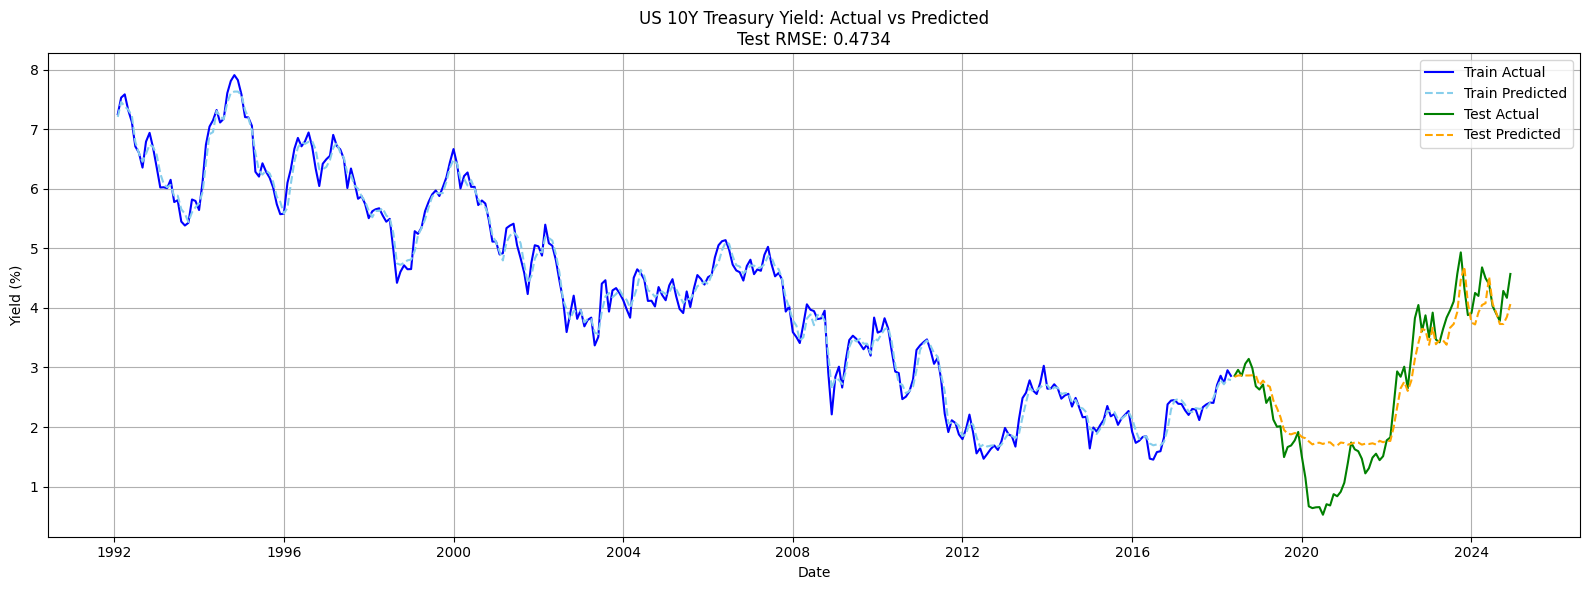

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_dates, y_train, label='Train Actual', color='blue')
plt.plot(train_dates, y_train_pred, label='Train Predicted', color='skyblue', linestyle='--')
plt.plot(test_dates, y_test, label='Test Actual', color='green')
plt.plot(test_dates, y_test_pred, label='Test Predicted', color='orange', linestyle='--')
plt.title(f'US 10Y Treasury Yield: Actual vs Predicted\nTest RMSE: {test_rmse:.4f}')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

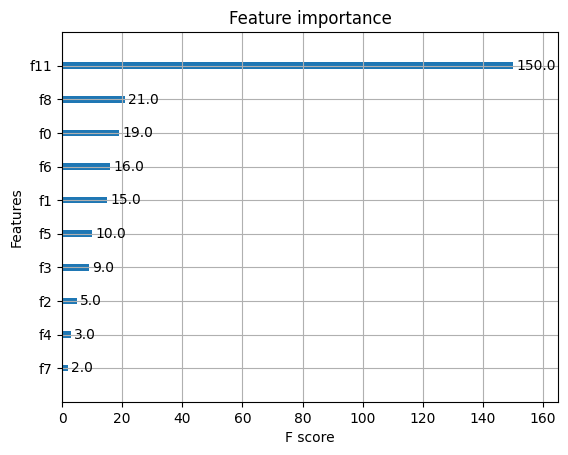

In [ ]:
plot_importance(best_model, max_num_features=10)
plt.show()

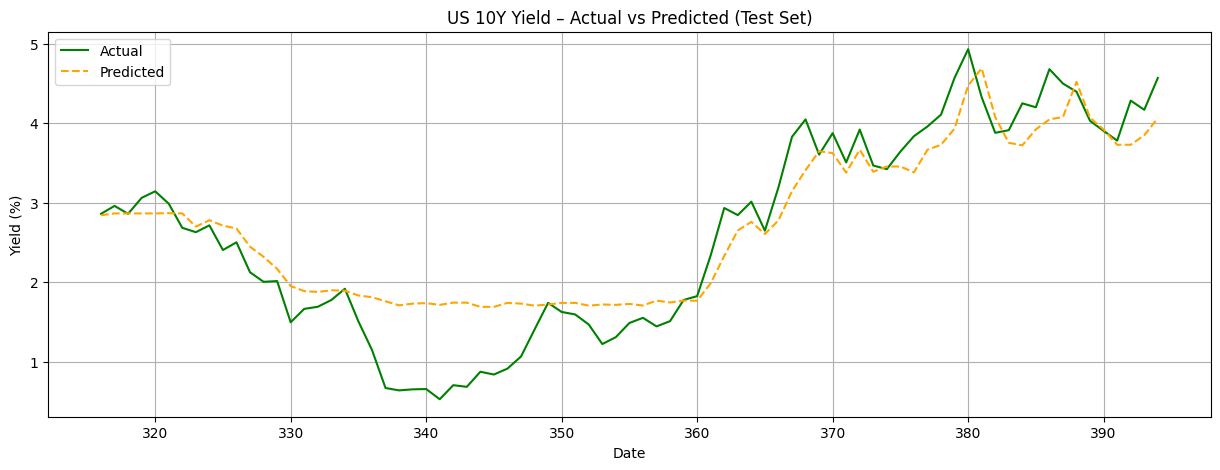

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label='Actual', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.title('US 10Y Yield – Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train WMAPE: {train_wmape:.2f}%")
print(f"Test WMAPE: {test_wmape:.2f}%")

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Train RMSE: 0.1509
Test RMSE: 0.4734
Train MAE: 0.1189
Test MAE: 0.3591
Train R²: 0.9921
Test R²: 0.8600
Train WMAPE: 2.76%
Test WMAPE: 13.71%


In [ ]:
params_df = pd.DataFrame(list(grid_search.best_params_.items()), columns=['Parameter', 'Value'])
print(params_df.to_string(index=False))

       Parameter  Value
colsample_bytree    1.0
           gamma    0.2
   learning_rate    0.1
       max_depth    3.0
    n_estimators  800.0
       reg_alpha    0.0
      reg_lambda    1.0
       subsample    0.8


In [ ]:
# First install required packages (uncomment if needed)
# !pip install xgboost pandas matplotlib scikit-learn openpyxl

import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor, plot_importance

# === 1. Data Loading & Preprocessing (One-time setup) ===
# NOTE: Ensure '/content/final_data.xlsx' exists in your environment
df = pd.read_excel('/content/final_data.xlsx', parse_dates=['Date'])

# Feature engineering
bond_yield = 'US TBill 10Y Yield(%)'
df['Yield_lag1'] = df[bond_yield].shift(1)
df['Yield_lag3'] = df[bond_yield].shift(3)
df['Yield_lag6'] = df[bond_yield].shift(6)
df['Yield_ma3'] = df[bond_yield].rolling(window=3).mean()
df['Yield_ma6'] = df[bond_yield].rolling(window=6).mean()
df['Yield_ma12'] = df[bond_yield].rolling(window=12).mean()
df = df.dropna().reset_index(drop=True)

X = df.drop(columns=['Date', bond_yield])
y = df[bond_yield]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# === 2. Timing Function ===
def run_xgboost_pipeline():
    """Core XGBoost process we want to time"""
    param_grid = {
        'n_estimators': [800, 1000],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 3],
        'gamma': [0.2, 0.5]
    }

    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_root_mean_squared_error',
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_train_normalized, y_train)
    best_model = grid_search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train_normalized)
    y_test_pred = best_model.predict(X_test_normalized)

    # Metrics
    return (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred)),
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred),
        grid_search.best_params_
    )

# === 3. Time Measurement ===
num_runs = 5  # Reduce if grid search is too slow
running_times = []
results = []

for _ in range(num_runs):
    start_time = time.time()
    metrics = run_xgboost_pipeline()
    running_times.append(time.time() - start_time)
    results.append(metrics)

# === 4. Results ===
avg_time = sum(running_times) / num_runs
print(f"\nAverage running time over {num_runs} runs: {avg_time:.2f} seconds")

# Show metrics from last run
train_rmse, test_rmse, train_r2, test_r2, best_params = results[-1]
print(f"\nBest Parameters: {best_params}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# === 5. Optional Plotting (excluded from timing) ===
# Add your plotting code here if needed



Average running time over 5 runs: 114.25 seconds

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Train RMSE: 0.1509
Test RMSE: 0.4734
Train R²: 0.9921
Test R²: 0.8600
